In [50]:
import pandas as pd
from io import StringIO
from markdown import Markdown
from sklearn.metrics import precision_score, accuracy_score, recall_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn import svm
from sklearn.decomposition import PCA
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
import json

# Syntactical Classification
import spacy
from spacy import displacy
from spacy.matcher import Matcher, DependencyMatcher


# GPT-3 Classification
import openai
from openai.embeddings_utils import get_embedding, cosine_similarity

In [2]:
annotated_df = pd.read_csv("/Users/finnmacken/Desktop/Code/ChatStructure/annotated.csv")
annotated_df = annotated_df.dropna(subset=['label'])
annotated_df = annotated_df[annotated_df.label != 'False#True']

In [3]:
def unmark_element(element, stream=None):
    if stream is None:
        stream = StringIO()
    if element.text:
        stream.write(element.text)
    for sub in element:
        unmark_element(sub, stream)
    if element.tail:
        stream.write(element.tail)
    return stream.getvalue()


# patching Markdown
Markdown.output_formats["plain"] = unmark_element
__md = Markdown(output_format="plain")
__md.stripTopLevelTags = False


def unmark(text):
    return __md.convert(text)

annotated_df['text'] = annotated_df['text'].astype(str)
annotated_df['text'] = annotated_df['text'].apply(unmark)

In [4]:
print(set(annotated_df['label']))
annotated_df['label'] = annotated_df['label'].map({"False": "Other", "True": "Request", "False#Unsure": "Unsure", "True#Unsure": "Unsure", "Unsure": "Unsure"})
print(set(annotated_df['label']))

{'False#Unsure', 'Unsure', 'False', 'True#Unsure', 'True'}
{'Request', 'Other', 'Unsure'}


# Utilities

In [5]:
openai.api_key = env("API_KEY")

In [38]:
actual_list = []

for label in annotated_df.label:
    if label == "Request":
        actual_list.append(1)
    else:
        actual_list.append(0)

In [41]:
def generate_confusion_matrix(actual, predicted, title, unsure):
    if unsure:    
        cm = confusion_matrix(actual, predicted, labels=["Request", "Other", "Unsure"])
        display = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels=["Request", "Other", "Unsure"]).plot()
        plt.title(f"Confusion Matrix for Feature Requests ({title})")
    else:
        cm = confusion_matrix(actual, predicted, labels=["Request", "Other"])
        display = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels=["Request", "Other"]).plot()
        plt.title(f"Confusion Matrix for Feature Requests ({title})")

# Generating Embeddings

In [54]:
def abridge_function(x):
    if len(x) > 7000:
        return x[:7000]

annotated_df['abridged_text'] = annotated_df['text'].apply(abridge_function)

In [55]:
json_text = annotated_df['abridged_text'].apply(json.dumps)
annotated_df["sim_embedding"] = json_text.apply(lambda x: get_embedding(x, engine="text-similarity-babbage-001"))

In [56]:
annotated_df.to_csv("/Users/finnmacken/Desktop/Code/ChatStructure/ProductionTestOutputs/sim_embeddings_df")

# Syntactical Methods

In [13]:
nlp = spacy.load("en_core_web_sm")
matcher = Matcher(nlp.vocab)

In [14]:
auxBe = [
    # this might be useful
    # this could be [a] [very] helpful [feature]
    [{"POS": "AUX"}, {"POS": "ADV", "OP": "*"}, {"LOWER": "be"}, {"POS": "DET"}, {"POS": "ADV", "OP": "*"}, {"LOWER": {"IN": ["great", "excellent", "amazing", "nice", "good", "awesome", 
                                                                                       "helpful", "useful", "terrific", "cool", 'like', 'love', 'appreciate', 'ideal', 'convenient'
                                                                                      ]}}], 
]

auxDesire = [
    [{"POS": "AUX", "TAG": {"IN": ["MD", "RB"]}}, {"POS": "ADV", "OP": "*"}, {"LOWER": {"IN": ['like', 'love', 'appreciate', 'want']}}]
]

pronounDesire = [
    [{"POS": "PRON"}, {"LOWER": {"IN": ["really", "desperately", "just", "only", "often", "actually"]}, "OP": "*"}, {"LOWER": {"IN": ['want', 'wish']}} ]
]

howAbout = [
    [{"LOWER": "how"}, {"LOWER": 'about'}]
]

couldPronoun = [
    # could we [also] do/be
    [{"LOWER": {"IN": ['could', 'can']}}, {"POS": "PRON"}, {"POS": "ADV", "OP": "*"}, {"POS": {"IN": ["VERB", "AUX"]}}]
]

pronounCould = [
    # we could [also] do/be
    # which could be
    # we can improve
  [{"POS": {"IN": ['you', 'we']}}, {"LOWER": {"IN": ['could']}}, {"POS": "ADV", "OP": "*"}, {"POS": {"IN": ["VERB", "AUX"]}}]  
]

auxPossibility = [ 
    # would it be possible
    # is it possible
    [{"POS": "AUX"}, {"POS": "PRON"}, {"POS": "AUX", "OP": "*"}, {"POS": "DET", "OP": "*"}, {"LOWER": {"IN": ['possible', 'possibility', 'option']}}]
]

possibilityVerb = [
    [{"LOWER": {"IN": ['possible', 'possibility']}}, {"POS": {"IN": ["PART", "ADP"]}}, {"POS": "VERB"}]
]

possibilityAdposition = [
    # possibility to
    [{"LOWER": {"IN": ['possible', 'possibility']}}, {"POS": "ADP"}]
]


noun_suggest_list = ['suggestion', 'idea', 'proposal', 'recommendation', 'submission', 'advice', 'proposition']

pronounSuggest = [
    # i suggest
    [{"POS": "PRON"}, {"LOWER": {'IN': ['suggest', 'propose', 'recommend', 'advocate', 'move', 'encourage']}}]
]

pronounSuggestionAux = [
    # my suggestion is
    # the idea is
    [{"POS": {"IN": ["PRON", "DET"]}}, {"LEMMA": {"IN": noun_suggest_list}}, {"POS": "AUX"}]
]

detNounSuggest = [
    # a couple of ideas
    # several suggestions
   [{"POS": "DET", "OP": "*"}, {"POS": {"IN": ['NOUN', "ADJ"]}}, {"POS": "ADP", "OP": "*"}, {"LEMMA": {"IN": noun_suggest_list}}]
]


shouldVerb = [
    # should [absolutely] be allowed to
    # should [absolutely] be created
    [{"LOWER": "should"}, {"POS": "ADV", "OP": "*"}, {"POS": "AUX", "OP": "*"}, {"POS": {"IN": ["VERB", "ADJ"]}}]
]

featureRequestPunct = [
    [{"LOWER": {"IN": ['feature', 'request', 'suggestion']}}, {"LOWER": {"IN": [":", 'for']}}]
]

hopeRequest = [
    [{"LOWER": "hope"}, {"LOWER": {"IN": ['you', 'that', 'we', 'there']}}]
]

whatIf = [
    [{"LOWER": "what"}, {"LOWER": 'if'}]
]

plannedTo = [
    [{"LOWER": {"IN": ["is", 'do', 'are']}}, {"POS": "PRON"}, {"POS": "DET", "OP": "*"}, {"LEMMA": "plan"}, {"POS": {"IN": ['PART', 'ADP']}}]
]

wayTo = [
    [{"LOWER": "is"}, {"LOWER": 'there'}, {"LOWER": "a"}, {"LOWER": 'way'}, {"LOWER": "to"}]
]


matcher.add("AuxBe", auxBe)

matcher.add("AuxDesire", auxDesire)
matcher.add("PronounDesire", pronounDesire)

matcher.add("HowAbout", howAbout)

matcher.add("CouldPronoun", couldPronoun)
matcher.add("PronounCould", pronounCould)

matcher.add("AuxPossibility", auxPossibility)
matcher.add("PossibilityVerb", possibilityVerb)
matcher.add("PossibilityAdposition", possibilityAdposition)

matcher.add("PronounSuggest", pronounSuggest)
matcher.add("PronounSuggestionAux", pronounSuggestionAux)
matcher.add("DetNounSuggest", detNounSuggest)

matcher.add("ShouldVerb", shouldVerb)

matcher.add("FeatureRequestPunct", featureRequestPunct)

matcher.add("HopeRequest", hopeRequest)

matcher.add("WhatIf", whatIf)

matcher.add("PlannedTo", plannedTo)
matcher.add("WayTo", wayTo)


In [22]:
def test_doc(doc_index, doc):
    matches = matcher(doc)
    if len(matches) != 0:
        print('\033[92m' + f"[{doc_index+1}] Match Found for: {doc.text}" + '\033[1m' + " ( " + ", ".join([nlp.vocab.strings[i[0]] for i in matches]) + " )" +  '\033[0m' + '\033[0m')
        for idx, match in enumerate(matches):
            print(f"Match {idx+1}: {doc[match[1]: match[2]]} ({match[1]}, {match[2]})")
        return 1
    else:
        print('\033[91m' + f"[{doc_index+1}] No match found for: {doc.text}" + '\033[0m') 
        return 0

In [27]:
def find_matches(df):
    matches_list = []
    docs = list(nlp.pipe(df.text))
    for idx, doc in enumerate(docs):
        matches_list.append(test_doc(idx, doc))
    return matches_list

In [28]:
annotated_df.head()

,id,text,created_at,author,reference,embeds,mentions,attachments,label
0,1019191342687072276,!history,2022-09-13 10:22:31.756000+00:00,finn,NaN,[],[],[],Other
1,1019075643096432781,thanks for the feedback! i'll discuss it with ...,2022-09-13 02:42:46.824000+00:00,Alan Chan,<MessageReference message_id=10190620301766164...,[],[<User id=174103652556996608 name='robotic_sca...,[],Other
2,1019062030176616458,a couple feature requests:\n\n\nit would be fa...,2022-09-13 01:48:41.251000+00:00,robotic_scarab,NaN,[],[],[<Attachment id=1019062029572649100 filename='...,Request
3,1019003148720951346,"yep, when letting go of the connection arrow i...",2022-09-12 21:54:42.818000+00:00,maxlinworm,<MessageReference message_id=10189863575924450...,[],[<User id=710847265581039616 name='Sams_Here' ...,[],Request
4,1018986357592445019,"if i may clarify, you want to create a new car...",2022-09-12 20:47:59.501000+00:00,Sams_Here,<MessageReference message_id=10189826926557266...,[],[<User id=776122030230732820 name='maxlinworm'...,[],Request


In [ ]:
matches_list = find_matches(annotated_df)

In [ ]:
matches_list

In [40]:
print("Precision:", precision_score(actual_list, matches_list))
print("Accuracy:", accuracy_score(actual_list, matches_list))
print("Recall:", recall_score(actual_list, matches_list))


Precision: 0.7567567567567568
Accuracy: 0.7132018209408194
Recall: 0.47058823529411764


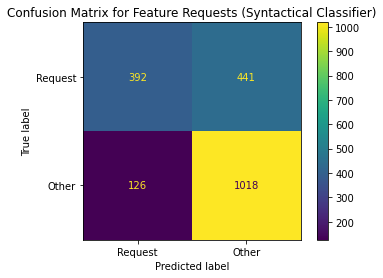

In [54]:
label_map = {
    1: "Request",
    0: "Other"
}

actual_list_labelled = [label_map[i] for i in actual_list]
matches_list_labelled = [label_map[i] for i in matches_list]

generate_confusion_matrix(actual_list_labelled, matches_list_labelled, "Syntactical Classifier", unsure=False)

# Support Vector Machines

In [57]:
# use pca to decrease dimension size
pca = PCA(n_components=200)

In [58]:
annotated_df.head()

,id,text,created_at,author,reference,embeds,mentions,attachments,label,abridged_text,sim_embedding
0,1019191342687072276,!history,2022-09-13 10:22:31.756000+00:00,finn,NaN,[],[],[],Other,None,"[0.007719679735600948, -0.017233144491910934, ..."
1,1019075643096432781,thanks for the feedback! i'll discuss it with ...,2022-09-13 02:42:46.824000+00:00,Alan Chan,<MessageReference message_id=10190620301766164...,[],[<User id=174103652556996608 name='robotic_sca...,[],Other,None,"[0.007682556752115488, -0.017111513763666153, ..."
2,1019062030176616458,a couple feature requests:\n\n\nit would be fa...,2022-09-13 01:48:41.251000+00:00,robotic_scarab,NaN,[],[],[<Attachment id=1019062029572649100 filename='...,Request,None,"[0.007719679735600948, -0.017233144491910934, ..."
3,1019003148720951346,"yep, when letting go of the connection arrow i...",2022-09-12 21:54:42.818000+00:00,maxlinworm,<MessageReference message_id=10189863575924450...,[],[<User id=710847265581039616 name='Sams_Here' ...,[],Request,None,"[0.007719679735600948, -0.017233144491910934, ..."
4,1018986357592445019,"if i may clarify, you want to create a new car...",2022-09-12 20:47:59.501000+00:00,Sams_Here,<MessageReference message_id=10189826926557266...,[],[<User id=776122030230732820 name='maxlinworm'...,[],Request,None,"[0.007719679735600948, -0.017233144491910934, ..."


In [59]:
index_split = 600

clf = svm.SVC()
X = annotated_df['sim_embedding'][:index_split]
y = actual_list[:index_split]

X_test = annotated_df['sim_embedding'][index_split:]
y_test = actual_list[index_split:]

In [60]:
X_reduced = pca.fit(X)
X_test_reduced = pca.fit(X_test)

In [ ]:
clf.fit(X_reduced, y)

In [ ]:
y_pred = clf.predict(X_test_reduced)

In [ ]:
print("Precision:", precision_score(y_test, y_pred))
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Recall:", recall_score(y_test, y_pred))


In [ ]:
generate_confusion_matrix(y_test, y_pred, "SVM Classifier", unsure=False)

# GPT-3

In [16]:
def generate_response(x):  
    # personal fine-tuned model trained to return "Request", "Other" or "Unsure"
    gpt_model = "text-davinci-002"
    res = openai.Completion.create(model=gpt_model, 
                                prompt= f"Tell me whether this message contains a feature request by answering Yes or No. Message: {x}. Contains feature request:", max_tokens=3, temperature=0)
    return res['choices'][0]['text']

In [18]:
test = annotated_df['text'][500]
print(test)
generate_response(test)

0                                               !history
1      thanks for the feedback! i'll discuss it with ...
2      a couple feature requests:\n\n\nit would be fa...
3      yep, when letting go of the connection arrow i...
4      if i may clarify, you want to create a new car...
                             ...                        
495                              can images be uploaded?
496                       thanks for the recommendation!
497    https://www.toketaware.com/ithoughts-howto-con...
498    when a card is folded, can a symbol or icon be...
499    i recently used a software called prodrafts on...
Name: text, Length: 500, dtype: object


' No'

In [20]:
test_df = annotated_df.text[:500]

In [21]:
predictions = test_df.apply(lambda x: generate_response(x))

In [30]:
predictions = predictions.apply(lambda x: x.strip())
predictions = predictions.apply(lambda x: x.replace("\n", ""))

In [ ]:
# annotated_df['davinci_prediction'] = annotated_df.text.apply(lambda x: generate_response(x))

In [43]:
predictions_array = predictions.map({"Yes": 1, "No": 0})

In [45]:
print("Precision:", precision_score(actual_list[:500], predictions_array))
print("Accuracy:", accuracy_score(actual_list[:500], predictions_array))
print("Recall:", recall_score(actual_list[:500], predictions_array))


Precision: 0.8032786885245902
Accuracy: 0.834
Recall: 0.8484848484848485


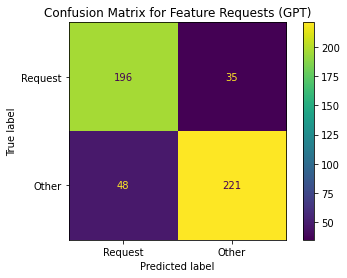

In [48]:
mapping_dict = {0: "Other", 1: "Request"}
generate_confusion_matrix([mapping_dict[i] for i in actual_list[:500]], [mapping_dict[i] for i in predictions_array], "GPT", unsure=False)

# GPT-3 (Fine-Tuned)

## Generating the Fine-Tuned Model

In [ ]:
annotated_df.to_json('feature-requests.jsonl', orient='records', lines=True)

! openai tools fine_tunes.prepare_data -f feature-requests.jsonl -q

In [ ]:
#os.environ["OPENAI_API_KEY"] = *******
#! export OPENAI_API_KEY=*******
#! openai api fine_tunes.create -t "feature-requests_prepared_train.jsonl" -m ada

# ^ run this in terminal to deal with the interactive prompts


## Applying the Fine Tuned Model

In [ ]:

def generate_response(x):  
    # personal fine-tuned model trained to return "Request", "Other" or "Unsure"
    ft_model = "ada:ft-personal-2022-09-30-15-57-04"
    res = openai.Completion.create(model=ft_model, 
                                prompt= f'{x}\n\n###\n\n', max_tokens=1, temperature=0)
    return res['choices'][0]['text']

generate_response(200)

In [ ]:
def classify_df(df):
    df['prediction'] = df['text'].apply(lambda x: generate_response(x))
    return df

In [ ]:
labelled_df = classify_df(annotated_df)

In [ ]:
labelled_df['prediction'] = labelled_df['prediction'].apply(lambda x: x.strip())

In [51]:
# Downloading from calculated data
# labelled_df = pd.read_csv("/Users/finnmacken/Desktop/Code/ChatStructure/ProductionTestOutputs/extracted_df")
# labelled_df.head()

In [62]:
actual_list = labelled_df.label
matches_list = labelled_df.prediction

label_map = {
    "Request": 1,
    "Other": 0,
    "Unsure": 0
}

actual_list = [label_map[i] for i in actual_list]
matches_list = [label_map[i] for i in matches_list]

print("Precision:", precision_score(actual_list, matches_list))
print("Accuracy:", accuracy_score(actual_list, matches_list))
print("Recall:", recall_score(actual_list, matches_list))


Counter({'Request': 704, 'Other': 153, 'Unsure': 3})

In [ ]:
label_map = {
    1: "Request",
    0: "Other"
}

actual_list_labelled = [label_map[i] for i in actual_list]
matches_list_labelled = [label_map[i] for i in matches_list]

generate_confusion_matrix(labelled_df.label, labelled_df.prediction, "GPT-3 (Fine-Tuned)", unsure=False)

# Clustering

# Saving Data

In [ ]:
annotated_df.to_csv("/Users/finnmacken/Desktop/Code/ChatStructure/ProductionTestOutputs/classification_output_df")